## Pronóstico del Indicador Mensual del Consumo Privado IMCP

Es un índice que mide el comportamiento del gasto de los hogares en México (consumidores).

In [ ]:
pip install pmdarima

In [19]:
# Librerias

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 

## especializadas 

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict

from statsmodels.tsa.arima.model import ARIMA

## pmdarima

import pmdarima as pm 

In [2]:
# Base de datos
datos= pd.read_csv('IMCP.csv')
datos

,Periodos,IMCP
0,2000/01,69.592772
1,2000/02,69.884806
2,2000/03,70.017659
3,2000/04,70.403639
4,2000/05,71.107793
...,...,...
278,2023/03,106.762443
279,2023/04,107.928291
280,2023/05,107.775653
281,2023/06,108.168118


Se eligio el periodo del 2000 - 2023 porque se mide la evolución del gasto realizado por los hogares en bienes y servicios de consumo, tanto de origen nacional como importado, permitiendo con ello dar seguimiento de forma mensual al componente más significativo del producto, por el lado de la demanda , sin embargo para mi fue preferible tomar del 2000 en adelante y aunque en las fechas del 2020 se presento la pandemia del COVID y en el 2009 la recesión mundial lo que son un componente irregular que representa la variabilidad aleatoria en las series de tiempo y es resultado de factores a corto plazo es importante para mi tomarlo en cuenta porque son datos que han afectado a este indicador y asi tenemos mas datos con los cuales basarnos para nuestro pronostico 

In [3]:
datos.dtypes

Periodos     object
IMCP        float64
dtype: object

In [4]:
## convertir en tiempo
## hacerlo index
## asignarle frecuencia 

datos['Periodos']=pd.to_datetime(datos['Periodos'],format='%Y/%m')
datos= datos.set_index('Periodos')
datos= datos.asfreq('MS')

In [5]:
datos.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01',
               '2023-06-01', '2023-07-01'],
              dtype='datetime64[ns]', name='Periodos', length=283, freq='MS')

In [6]:
## missing values 

datos.isnull().sum()

IMCP    0
dtype: int64

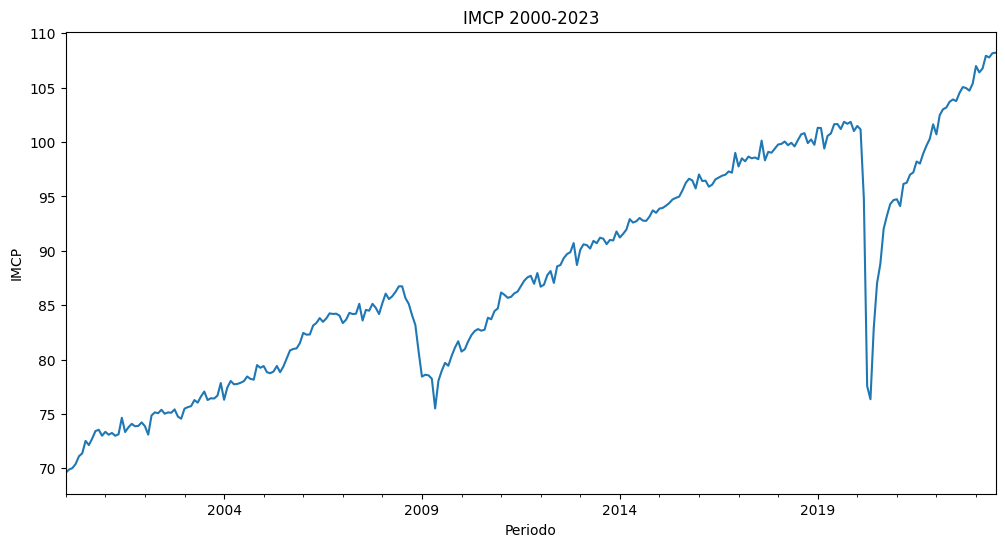

In [36]:
## grafcar serie 

datos['IMCP'].plot(figsize=(12,6))
plt.xlabel('Periodo')
plt.ylabel('IMCP')
plt.title('IMCP 2000-2023');


Realiza un pronostico del Indice

In [8]:
## prueba de dickey-fuller aumentada

prueba_adf= adfuller(datos['IMCP'])
pvalue= prueba_adf[1]
pvalue.round(2)

0.71

No rechazamos $H_0$ , el IMCP es una serie no estacionaria

In [9]:
## primeras diferencias 

datos['IMCP_diff']=datos['IMCP'].diff()

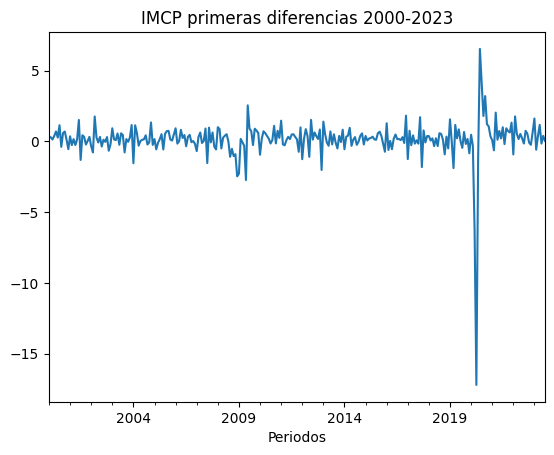

In [37]:
datos['IMCP_diff'].plot();

plt.title('IMCP primeras diferencias 2000-2023');

In [14]:
prueba_adf= adfuller(datos['IMCP_diff'].dropna())
pvalue1= prueba_adf[1]
pvalue1.round(2)

0.0

Rechazamos $H_0$ , las primeras diferencias de desempleo son una serie estacionaria

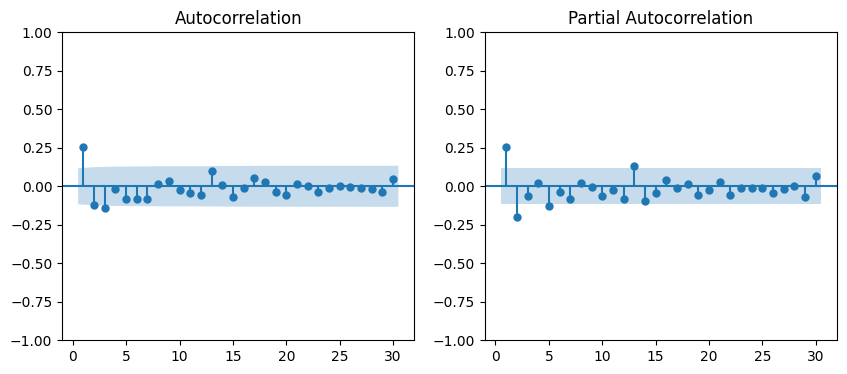

In [16]:
## graficas de correlación 

ig,ax= plt.subplots(1,2,figsize=(10,4))

## 1er 
plot_acf(datos['IMCP_diff'].dropna(),zero=False,lags=30,ax=ax[0])

## 2 da
plot_pacf(datos['IMCP_diff'].dropna(),zero=False,lags=30,ax=ax[1]);


Con las graficas de correlacion dado que emerge un patron que se repite , estamos ante una serie estacional , es decir, hay meses que el IMCP siempre sube o meses que el IMCP siempre baja

In [21]:
## Encontrar el orden del SARIMA

pm.auto_arima(datos['IMCP'],
              start_p=1,start_q=1,
              max_p=7,max_q=7,
              ic='aic',
              seasonal=True,
              m=12,
              start_P=1, start_Q=1,
              max_P=7, max_Q=7
              )

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True)

EL IMCP es un SARIMA (0,1,3)(0,0,1,12)

In [22]:
## modelo

model= ARIMA(datos['IMCP'],
             order=(0,1,3),
             seasonal_order=(0,0,1,12))

results=model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               IMCP   No. Observations:                  283
Model:             ARIMA(0, 1, 3)x(0, 0, [1], 12)   Log Likelihood                -478.131
Date:                            Tue, 31 Oct 2023   AIC                            966.262
Time:                                    20:35:42   BIC                            984.471
Sample:                                01-01-2000   HQIC                           973.564
                                     - 07-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3245      0.035      9.355      0.000       0.257       0.393
ma.L2         -0.0970      0.041   

In [23]:
datos['IMCP_arima']=results.predict()

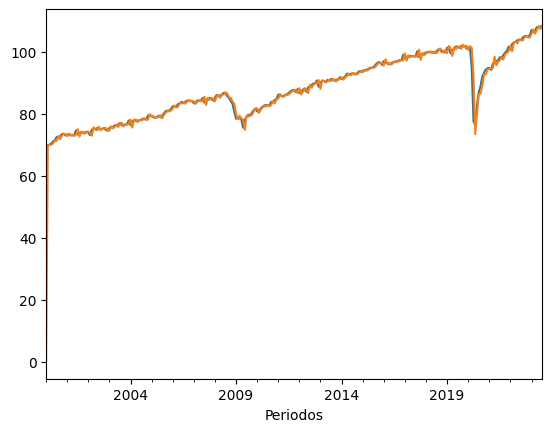

In [24]:
datos['IMCP'].plot()
datos['IMCP_arima'].plot();


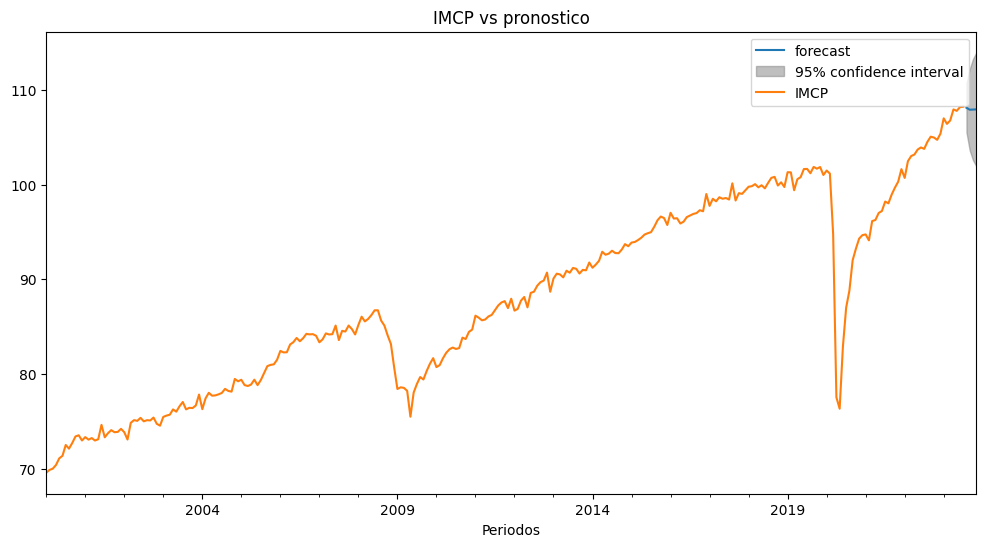

In [28]:
# grafica del pronostico futuro 
plot_predict(results,'2023-08-01','2023-11-01')
datos['IMCP'].plot(figsize=(12,6))
plt.title('IMCP vs pronostico')
plt.legend()
plt.show()

In [25]:
datos.tail()

,IMCP,IMCP_diff,IMCP_arima
Periodos,,,
2023-03-01,106.762443,0.361856,105.822179
2023-04-01,107.928291,1.165848,106.913003
2023-05-01,107.775653,-0.152638,108.239445
2023-06-01,108.168118,0.392465,107.327164
2023-07-01,108.209387,0.041269,108.304781


Pronostico con los intervalos 

In [29]:
forecast= results.get_forecast(steps=4)
forecast_mean= forecast.predicted_mean
forecast_ci= forecast.conf_int()

In [30]:
inicio= '2023-08-01'
fin='2023-11-01'

In [31]:
pronostico_valor= forecast_mean[inicio:fin]
pronostico_intervalos= forecast_ci.loc[inicio:fin]

In [32]:
pro_IMCP= pd.DataFrame({
    'pronostico': pronostico_valor,
    'limite inferior': pronostico_intervalos.iloc[:,0],
    'limite superior': pronostico_intervalos.iloc[:,1]
})

In [33]:
pro_IMCP

,pronostico,limite inferior,limite superior
2023-08-01,108.104704,105.521878,110.687530
2023-09-01,107.896449,103.609889,112.183009
2023-10-01,107.913938,102.582269,113.245607
2023-11-01,107.930839,101.951315,113.910362


In [35]:
print(f'Para agosto pronosticamos un IMCP de :{pro_IMCP.iloc[0,0].round(4)}% \n pero puede estar entre:{pro_IMCP.iloc[0,1].round(2)}% y {pro_IMCP.iloc[0,2].round(2)}% con 95% de confianza')

Para agosto pronosticamos un IMCP de :108.1047% 
 pero puede estar entre:105.52% y 110.69% con 95% de confianza
